## Soft Actor Critic (SAC) ##

Основные характеристики:
1) Model-free
2) Off-Policy
3) Actor-Critic архитектура, (1 актер, 2 критика)
5) Максимизация энтропии (учитываем не только награду, но и исследования через энтропию)

Структура:

<img src="SAC-algorithm.png">

In [1]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
class StablePendulumEnv(gym.Wrapper):
    def __init__(self, angle_threshold=0.1, velocity_threshold=0.1):
        env = gym.make("Pendulum-v1")
        super().__init__(env)
        
        self.angle_threshold = angle_threshold
        self.velocity_threshold = velocity_threshold
        
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        
        theta = np.arctan2(obs[1], obs[0])
        theta_dot = obs[2]
        
        if (abs(theta) < self.angle_threshold) and (abs(theta_dot) < self.velocity_threshold):
            terminated = True
        
        return obs, reward, terminated, truncated, info


def create_env(mode=None, fast=False):
    if fast:
        env = StablePendulumEnv(angle_threshold=0.1, velocity_threshold=0.1)
    else:
        env = gym.make("Pendulum-v1", render_mode=mode)  # Классический Pendulum из Gym
    env = Monitor(env, "./logs/")  # Логирование статистики
    env = DummyVecEnv([lambda: env])
    return env

In [3]:
env = create_env(fast=True)

if True:
    model = SAC(
        "MlpPolicy",
        env,
        device='cpu',
        verbose=1,
        learning_rate=3e-4,
        buffer_size=100_000,
        batch_size=256,
        ent_coef='auto',  # Автонастройка энтропии
        gamma=0.99,
        tau=0.005,
    )
else:
    model = SAC.load("./best_model/best_model", env=env)

Using cpu device


In [1]:
eval_callback = EvalCallback(
    env,
    best_model_save_path="./best_model/",
    log_path="./logs/",
    eval_freq=1000,           # Частота оценки (в шагах)
    deterministic=True
)
# 3. Обучаем агента (10,000 шагов для демо)
model.learn(total_timesteps=10_000, progress_bar=True, callback=eval_callback)

# model.save("./sac_cartpole")
# print("Модель сохранена в sac_cartpole.zip")

NameError: name 'asdasd' is not defined

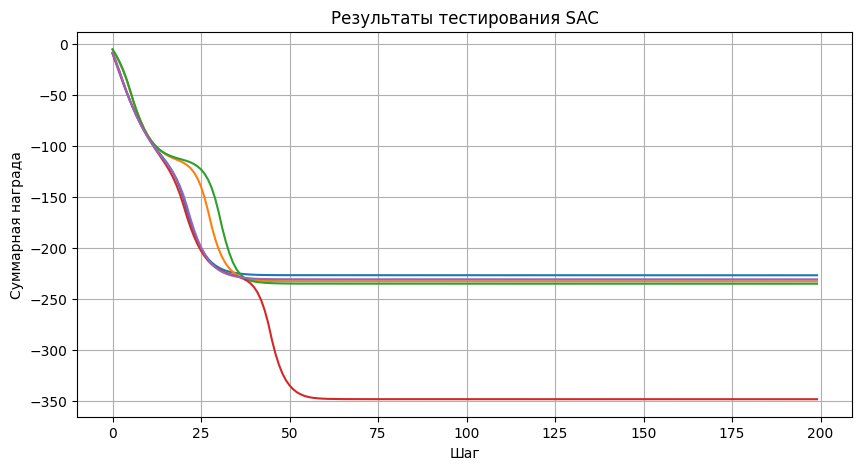

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [5]:
best_model = SAC.load("./best_model/best_model")
best_model = model
test_env = create_env("human")
rewards = [[]]

# 4. Тестируем агента
obs = test_env.reset()
for _ in range(1000):
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, _ = test_env.step(action)  # Gym возвращает 4 значения (без info)
    rewards[-1].append(reward[0])
    if done:
        rewards.append([])
        obs = test_env.reset()
test_env.close()

# 8. Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(np.swapaxes(np.cumsum(rewards[:-1], axis=1), 0, 1))
plt.xlabel("Шаг")
plt.ylabel("Суммарная награда")
plt.title("Результаты тестирования SAC")
plt.grid()
plt.savefig("./sac_performance.png")
plt.show()

# 9. Вывод статистики
print(f"Средняя награда за 1000 шагов: {np.mean(rewards):.2f}")
print(f"Максимальная награда: {np.max(rewards)}")

In [11]:
from stable_baselines3.common.vec_env import VecVideoRecorder
from datetime import datetime
# 1. Создаем среду
env = create_env("rgb_array")

# 2. Загружаем обученную модель (или обучаем с нуля)
model = SAC.load("./best_model/best_model")  # Путь к вашей модели

# 4. Обертка для записи видео
video_length=1000
env = VecVideoRecorder(
    env,
    "./videos/",
    record_video_trigger=lambda x: x == 0,  # Запись сразу
    video_length=video_length,
    name_prefix="sac_cartpole_video" + datetime.now().strftime("%Y%m%d_%H%M%S")
)

# 5. Запуск агента и запись
obs = env.reset()
for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, _, _ = env.step(action)

env.close()  # Видео сохранится автоматически

[[-0.59088945 -0.80675256  0.83110577]]
[[-1.0000000e+00  1.2246469e-16  0.0000000e+00]]
Saving video to C:\Users\4ert\Desktop\учеба\REI\videos\sac_cartpole_video20250511_043311-step-0-to-step-1000.mp4
MoviePy - Building video C:\Users\4ert\Desktop\учеба\REI\videos\sac_cartpole_video20250511_043311-step-0-to-step-1000.mp4.
MoviePy - Writing video C:\Users\4ert\Desktop\учеба\REI\videos\sac_cartpole_video20250511_043311-step-0-to-step-1000.mp4


MoviePy - Done !
MoviePy - video ready C:\Users\4ert\Desktop\учеба\REI\videos\sac_cartpole_video20250511_043311-step-0-to-step-1000.mp4


In [13]:
class ControllablePendulumEnv(gym.Wrapper):
    def __init__(self):
        env = gym.make("Pendulum-v1", render_mode="rgb_array")
        super().__init__(env)
        self._init_angle = None
        self._init_velocity = None

    def set_init_state(self, angle, velocity):
        """Установить начальный угол (в радианах) и скорость."""
        self._init_angle = angle
        self._init_velocity = velocity

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if self._init_angle is not None and self._init_velocity is not None:
            # Принудительно задаём состояние
            self.unwrapped.state = np.array(
                [self._init_angle, self._init_velocity], 
                dtype=np.float32
            )
            obs = np.array([
                np.cos(self._init_angle),
                np.sin(self._init_angle),
                self._init_velocity
            ], dtype=np.float32)
        return obs, info

# Пример использования
env = ControllablePendulumEnv()
env.set_init_state(angle=np.pi, velocity=0)  
env = Monitor(env, "./logs/")
env = DummyVecEnv([lambda: env])

model = SAC.load("./best_model/best_model")

video_length=1000
env = VecVideoRecorder(
    env,
    "./videos/",
    record_video_trigger=lambda x: x == 0,
    video_length=video_length,
    name_prefix="sac_cartpole_video" + datetime.now().strftime("%Y%m%d_%H%M%S")
)

obs = env.reset()
for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, _, _ = env.step(action)

env.close() 

Saving video to C:\Users\4ert\Desktop\учеба\REI\videos\sac_cartpole_video20250511_043556-step-0-to-step-1000.mp4
MoviePy - Building video C:\Users\4ert\Desktop\учеба\REI\videos\sac_cartpole_video20250511_043556-step-0-to-step-1000.mp4.
MoviePy - Writing video C:\Users\4ert\Desktop\учеба\REI\videos\sac_cartpole_video20250511_043556-step-0-to-step-1000.mp4


MoviePy - Done !
MoviePy - video ready C:\Users\4ert\Desktop\учеба\REI\videos\sac_cartpole_video20250511_043556-step-0-to-step-1000.mp4
